In [1]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 6.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Cross-Validation RMSE Scores: [33613.87249558 23488.53220271 19550.66773632 18785.6697482
 18334.73553315]
Mean Cross-Validation RMSE: 22754.695543194382
Cross-Validation R^2 Scores: [0.83821935 0.91983719 0.92412279 0.9197616  0.92822651]
Mean Cross-Validation R^2: 0.9060334874023074
              Feature  Importance
5         OverallQual    0.484650
1           GrLivArea    0.157225
13        TotalBsmtSF    0.061027
7           YearBuilt    0.042579
10         BsmtFinSF1    0.034234
14           1stFlrSF    0.033523
27         GarageArea    0.032282
24         Fireplaces    0.022239
4             LotArea    0.016515
15           2ndFlrSF    0.015000
26         GarageCars    0.014338
186       BsmtQual_Ex    0.010462
8        YearRemodAdd    0.009330
6         OverallCond    0.007133
254  GarageFinish_Unf    0.006316
19           FullBath    0.005449
233    KitchenQual_TA    0.005047
171      ExterQual_Ex    0.003476
9          MasVnrArea    0.003229
223      CentralAir_N    0.002391


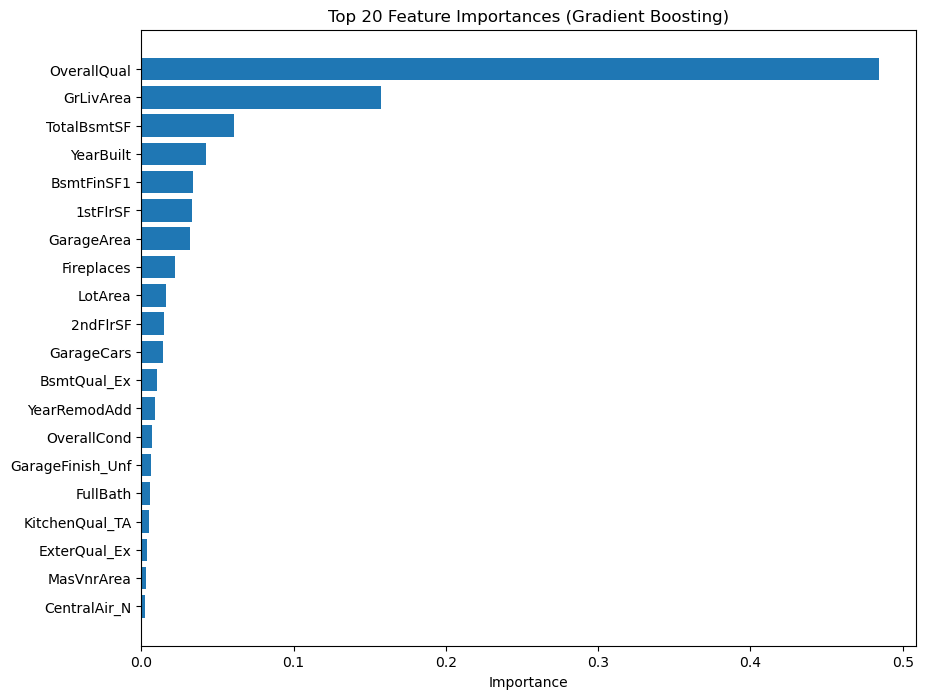

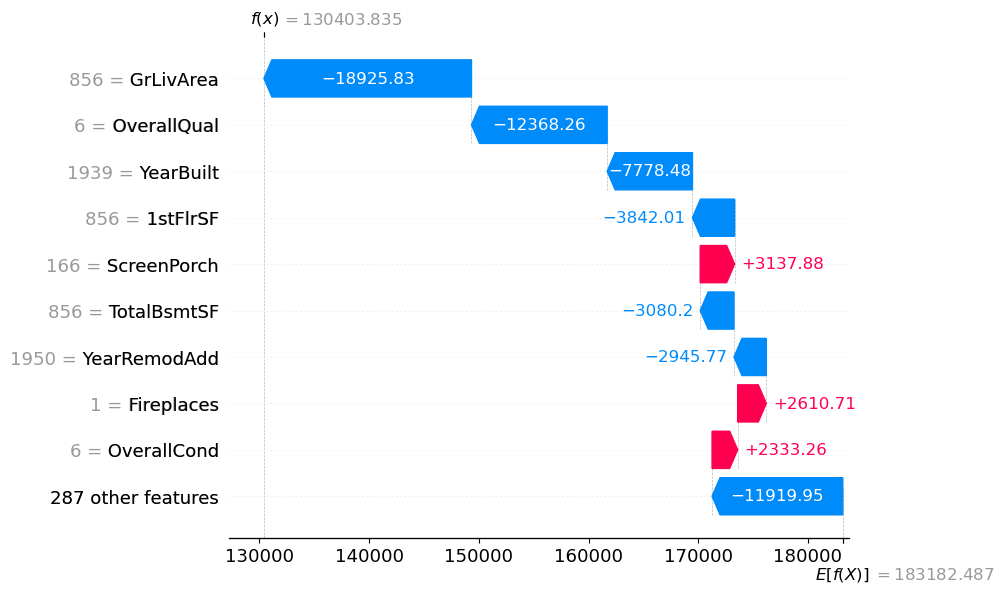

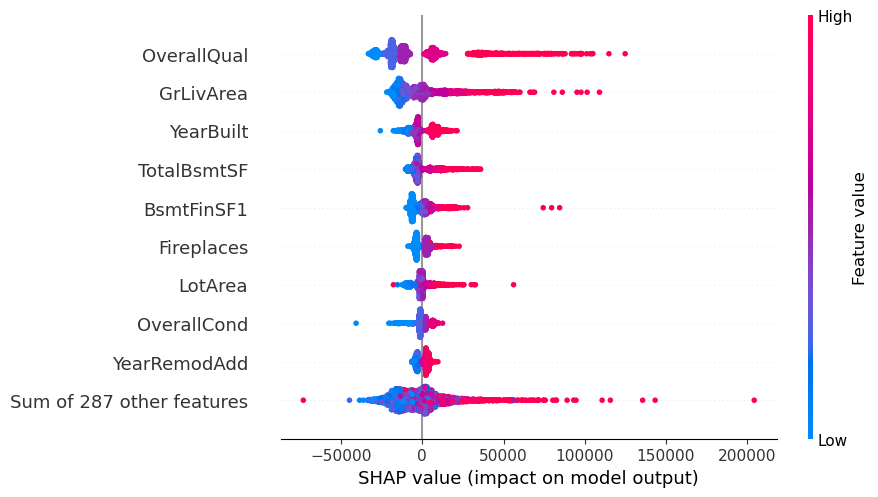

In [3]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# Load the dataset
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)

# Define features and target variable
X = housing.drop('SalePrice', axis=1)
y = housing['SalePrice']


# Drop PID and empty columns
housing.drop(columns=['PID'], inplace=True)
housing.dropna(axis=1, how='all', inplace=True)

# Preprocessing pipeline for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the Gradient Boosting pipeline
pipeline_gradient_boosting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

# Define a scorer for cross-validation
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Perform cross-validation for RMSE
cv_rmse_scores = cross_val_score(pipeline_gradient_boosting, X, y, cv=5, scoring=scorer)

# Perform cross-validation for R^2
cv_r2_scores = cross_val_score(pipeline_gradient_boosting, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print(f'Cross-Validation RMSE Scores: {-cv_rmse_scores}')
print(f'Mean Cross-Validation RMSE: {-cv_rmse_scores.mean()}')
print(f'Cross-Validation R^2 Scores: {cv_r2_scores}')
print(f'Mean Cross-Validation R^2: {cv_r2_scores.mean()}')

import matplotlib.pyplot as plt
import numpy as np

# Fit the pipeline on the entire dataset
pipeline_gradient_boosting.fit(X, y)

# Extract feature importances
model = pipeline_gradient_boosting.named_steps['model']
importances = model.feature_importances_

# Get the feature names
onehot_encoder = pipeline_gradient_boosting.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = onehot_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, encoded_cat_features])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 20 features
top_20_features = feature_importance_df.head(20)

# Print the top 20 feature importances
print(top_20_features)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.show()

import shap

# SHAP values
preprocessed_X = pipeline_gradient_boosting.named_steps['preprocessor'].transform(X).toarray()  # Convert to dense array
explainer = shap.Explainer(model, preprocessed_X, feature_names=all_features)
shap_values = explainer(preprocessed_X)

# Select a sample for the waterfall plot
sample_ind = 0

# Waterfall plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.waterfall_plot(shap_values[sample_ind])

# SHAP beeswarm plot for global feature importance
shap.plots.beeswarm(shap_values)

Cross-Validation RMSE Scores: [31507.59007766 24754.08978144 21237.80137144 19609.50728363
 19266.11909095]
Mean Cross-Validation RMSE: 23275.021521024
Cross-Validation R^2 Scores: [0.85785884 0.91096616 0.91046203 0.91256964 0.92074927]
Mean Cross-Validation R^2: 0.9025211881009003
                  Feature  Importance
5             OverallQual    0.351757
254      GarageFinish_Unf    0.052820
14               1stFlrSF    0.050410
43            MSZoning_RM    0.046300
26             GarageCars    0.046204
186           BsmtQual_Ex    0.043135
229        KitchenQual_Ex    0.031542
1               GrLivArea    0.028083
223          CentralAir_N    0.027133
24             Fireplaces    0.017540
233        KitchenQual_TA    0.017334
267          PavedDrive_Y    0.016230
202      BsmtFinType1_GLQ    0.010823
171          ExterQual_Ex    0.010456
8            YearRemodAdd    0.009516
63          LandSlope_Gtl    0.009256
22           KitchenAbvGr    0.009212
13            TotalBsmtSF    0.0

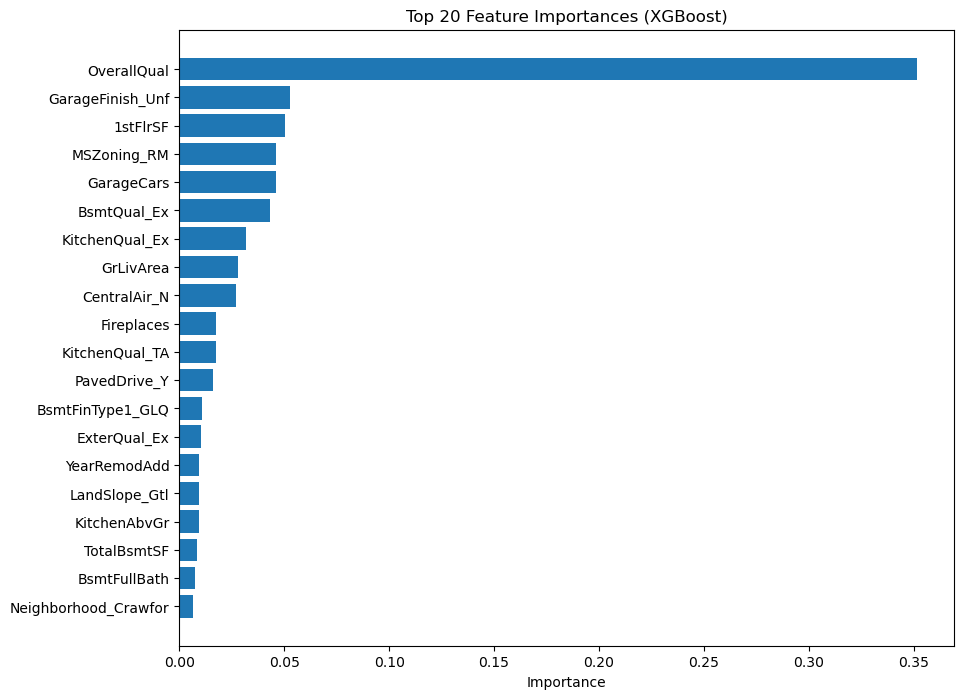

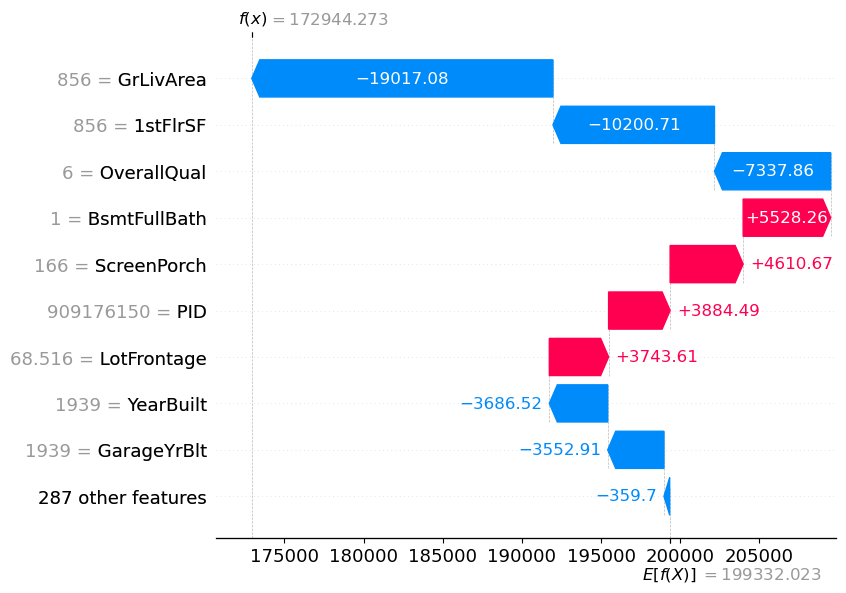

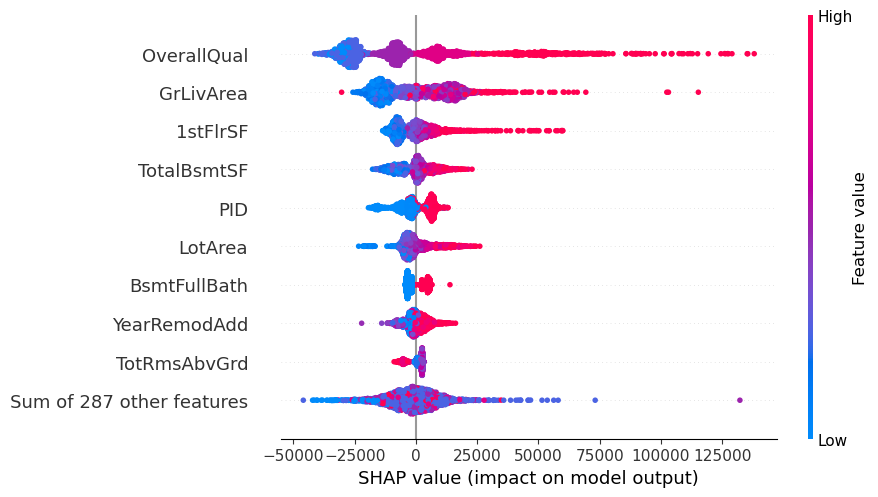

In [6]:
#top 20 feature
from xgboost import XGBRegressor
import shap


# Define the XGBoost pipeline
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, random_state=42, reg_lambda=1))
])

# Define a scorer for cross-validation
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Perform cross-validation for RMSE
cv_rmse_scores = cross_val_score(pipeline_xgboost, X, y, cv=5, scoring=scorer)

# Perform cross-validation for R^2
cv_r2_scores = cross_val_score(pipeline_xgboost, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print(f'Cross-Validation RMSE Scores: {-cv_rmse_scores}')
print(f'Mean Cross-Validation RMSE: {-cv_rmse_scores.mean()}')
print(f'Cross-Validation R^2 Scores: {cv_r2_scores}')
print(f'Mean Cross-Validation R^2: {cv_r2_scores.mean()}')

# Fit the pipeline on the entire dataset
pipeline_xgboost.fit(X, y)

# Extract feature importances
model = pipeline_xgboost.named_steps['model']
importances = model.feature_importances_

# Get the feature names
onehot_encoder = pipeline_xgboost.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = onehot_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, encoded_cat_features])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 20 features
top_20_features = feature_importance_df.head(20)

# Print the top 20 feature importances
print(top_20_features)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

#shap
preprocessed_X = pipeline_xgboost.named_steps['preprocessor'].transform(X).toarray()  # Convert to dense array
explainer = shap.Explainer(model, preprocessed_X, feature_names=all_features)
shap_values = explainer(preprocessed_X)

# Select a sample for the waterfall plot
sample_ind = 0

# Waterfall plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.waterfall_plot(shap_values[sample_ind])

# SHAP beeswarm plot for global feature importance
shap.plots.beeswarm(shap_values)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__reg_alpha': 0.1, 'model__reg_lambda': 1}
Best Model Cross-Validation RMSE Scores: [30580.81650467 22400.55720047 18023.67753191 16939.06796919
 17064.18253474]
Best Model Mean Cross-Validation RMSE: 21001.660348197176
Best Model Cross-Validation R^2 Scores: [0.86609782 0.92709139 0.93551259 0.93476091 0.9378293 ]
Best Model Mean Cross-Validation R^2: 0.9202584008489957
               Feature  Importance
5          OverallQual    0.170281
26          GarageCars    0.134147
186        BsmtQual_Ex    0.082710
254   GarageFinish_Unf    0.064730
251  GarageType_Detchd    0.051385
1            GrLivArea    0.034948
233     KitchenQual_TA    0.034444
14            1stFlrSF    0.034019
27          GarageArea    0.030960
24          Fireplaces    0.029719
13         TotalBsmtSF    0.026262
171       ExterQual_Ex    0.0234

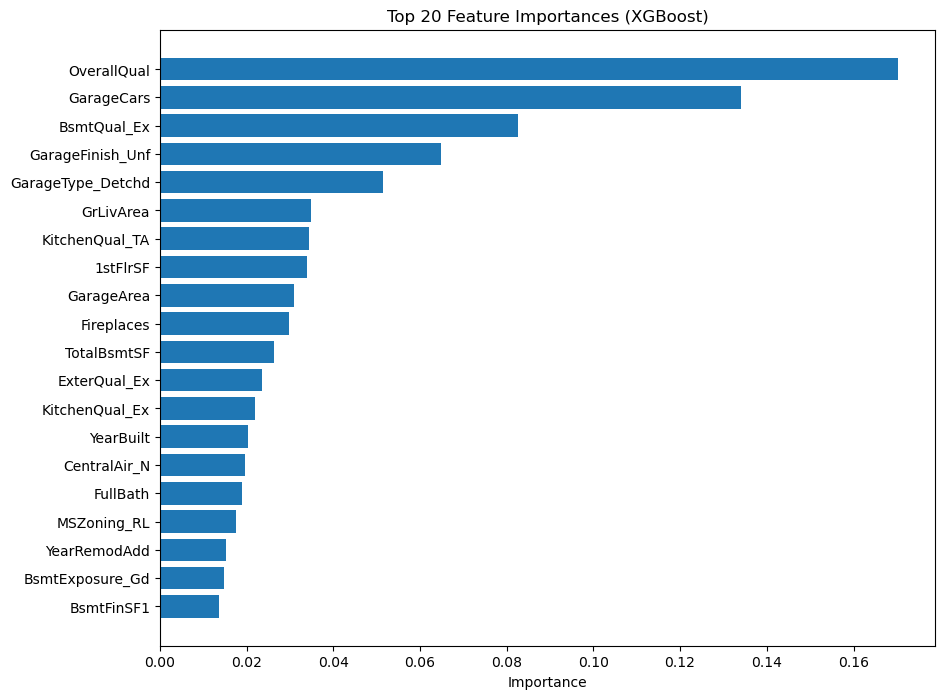

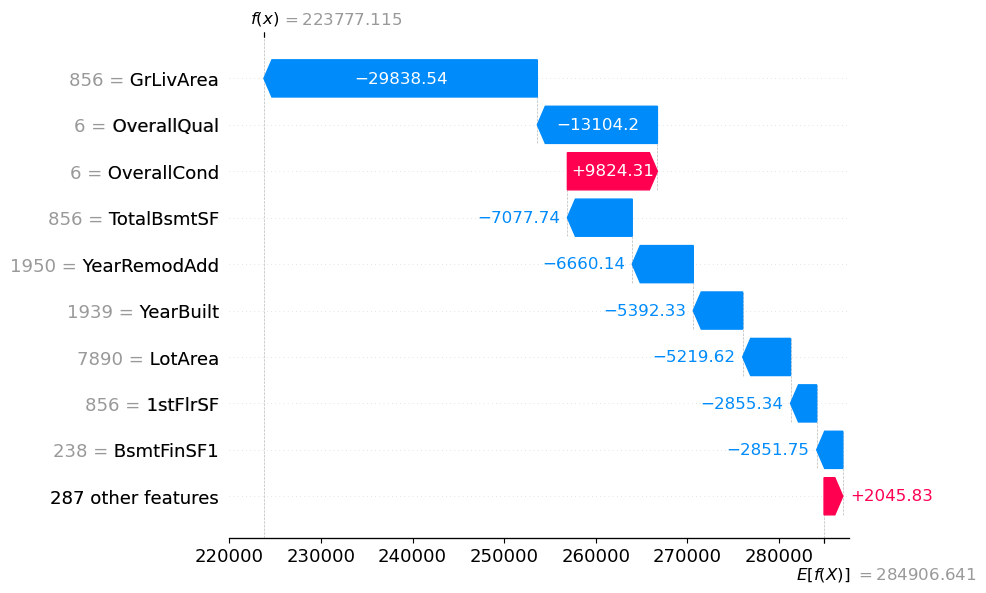

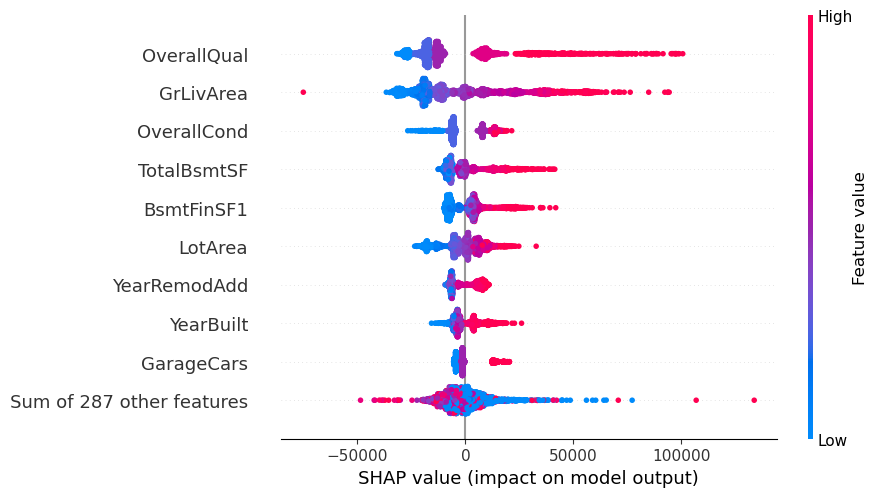

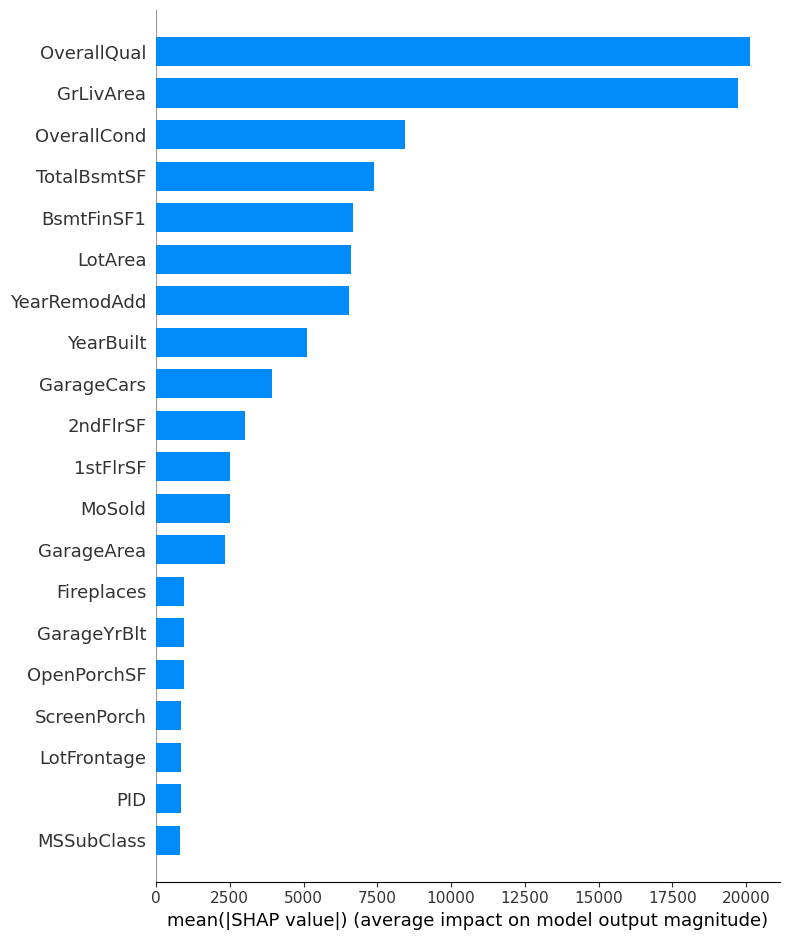

In [7]:
#best result 
from sklearn.model_selection import GridSearchCV
# Define the XGBoost pipeline
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__reg_lambda': [1, 5, 10],
    'model__reg_alpha': [0, 0.1, 0.5]
}

# Define the scorer for GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline_xgboost, param_grid, cv=5, scoring=scorer, n_jobs=-1, verbose=1)

# Perform GridSearchCV
grid_search.fit(X, y)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Perform cross-validation for RMSE and R^2 on the best model
cv_rmse_scores = cross_val_score(best_model, X, y, cv=5, scoring=scorer)
cv_r2_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print(f'Best Model Cross-Validation RMSE Scores: {-cv_rmse_scores}')
print(f'Best Model Mean Cross-Validation RMSE: {-cv_rmse_scores.mean()}')
print(f'Best Model Cross-Validation R^2 Scores: {cv_r2_scores}')
print(f'Best Model Mean Cross-Validation R^2: {cv_r2_scores.mean()}')

# Extract feature importances from the best model
model = best_model.named_steps['model']
importances = model.feature_importances_

# Get the feature names
onehot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = onehot_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, encoded_cat_features])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 20 features
top_20_features = feature_importance_df.head(20)

# Print the top 20 feature importances
print(top_20_features)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

# SHAP values
preprocessed_X = best_model.named_steps['preprocessor'].transform(X).toarray()  # Convert to dense array
explainer = shap.Explainer(model, preprocessed_X, feature_names=all_features)
shap_values = explainer(preprocessed_X)

# Select a sample for the waterfall plot
sample_ind = 0

# Waterfall plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.waterfall_plot(shap_values[sample_ind])

# SHAP beeswarm plot for global feature importance
shap.plots.beeswarm(shap_values)

# SHAP summary plot (bar)
shap.summary_plot(shap_values, preprocessed_X, feature_names=all_features, plot_type="bar")


In [32]:
# paramerter tunning with bigger range and use randomsearchcv
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
# Create a pipeline that preprocesses the data and then applies the XGBoost model
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define the parameter grid for RandomizedSearchCV
param_dist_xgb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2]
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(pipeline_xgboost, param_distributions=param_dist_xgb, n_iter=50, cv=3, scoring='r2', n_jobs=-1, random_state=42)
random_search_xgb.fit(X, y)

# Get the best model and parameters
best_model_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_

# Cross-validated performance metrics for the best model
cv_rmse_scores_xgb = cross_val_score(best_model_xgb, X, y, cv=3, scoring='neg_mean_squared_error')
cv_r2_scores_xgb = cross_val_score(best_model_xgb, X, y, cv=3, scoring='r2')

print(f'Best Parameters for XGBoost: {best_params_xgb}')
print(f'Cross-Validation RMSE Scores (XGBoost): {np.sqrt(-cv_rmse_scores_xgb)}')
print(f'Mean Cross-Validation RMSE (XGBoost): {np.sqrt(-cv_rmse_scores_xgb).mean()}')
print(f'Cross-Validation R^2 Scores (XGBoost): {cv_r2_scores_xgb}')
print(f'Mean Cross-Validation R^2 (XGBoost): {cv_r2_scores_xgb.mean()}')

Best Parameters for XGBoost: {'model__subsample': 0.8, 'model__reg_lambda': 1.5, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.6}
Cross-Validation RMSE Scores (XGBoost): [27235.29823357 19888.06305513 18293.88936308]
Mean Cross-Validation RMSE (XGBoost): 21805.75021726165
Cross-Validation R^2 Scores (XGBoost): [0.89410365 0.92566004 0.9256283 ]
Mean Cross-Validation R^2 (XGBoost): 0.9151306625704697


In [ ]:

# Create a pipeline that preprocesses the data and then applies the XGBoost model
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid_xgb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(pipeline_xgboost, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X, y)

# Get the best model and parameters
best_model_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

# Cross-validated performance metrics for the best model
cv_rmse_scores_xgb = cross_val_score(best_model_xgb, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores_xgb = cross_val_score(best_model_xgb, X, y, cv=5, scoring='r2')

print(f'Best Parameters for XGBoost: {best_params_xgb}')
print(f'Cross-Validation RMSE Scores (XGBoost): {np.sqrt(-cv_rmse_scores_xgb)}')
print(f'Mean Cross-Validation RMSE (XGBoost): {np.sqrt(-cv_rmse_scores_xgb).mean()}')
print(f'Cross-Validation R^2 Scores (XGBoost): {cv_r2_scores_xgb}')
print(f'Mean Cross-Validation R^2 (XGBoost): {cv_r2_scores_xgb.mean()}')